# Detoxification task
## paraNMT dataset exploration

#### By: Vladislav Urzhumov, B21-AI-01 at Innopolis University


> Firstly, I have to note that Github argues with those who try to upload decompressed .tsv file there, since it is larger than 100MiB. Thus, we are using compressed file decompression in the preprocessin

#### This notebook has dataset exploration and figures

There is no model training or prediction. However, here we can experiment with data and look at it's distribution.

To start with, let us extract the data into pandas Dataframe and check it

In [ ]:
import seaborn as sns
import pandas as pd
import zipfile
import io
import matplotlib.pyplot as plt
%matplotlib inline


FILEPATH = 'filtered_paranmt.zip'


def unzip_tsv(filepath=FILEPATH):
    with zipfile.ZipFile(filepath, 'r') as zip_ref:
        file_content = zip_ref.read("filtered.tsv").decode("utf-8")
    df = pd.read_csv(io.StringIO(file_content), sep="\t")
    return df


df = unzip_tsv()


df

,Unnamed: 0,reference,translation,similarity,lenght_diff,ref_tox,trn_tox
0,0,"If Alkar is flooding her with psychic waste, t...","if Alkar floods her with her mental waste, it ...",0.785171,0.010309,0.014195,0.981983
1,1,Now you're getting nasty.,you're becoming disgusting.,0.749687,0.071429,0.065473,0.999039
2,2,"Well, we could spare your life, for one.","well, we can spare your life.",0.919051,0.268293,0.213313,0.985068
3,3,"Ah! Monkey, you've got to snap out of it.","monkey, you have to wake up.",0.664333,0.309524,0.053362,0.994215
4,4,I've got orders to put her down.,I have orders to kill her.,0.726639,0.181818,0.009402,0.999348
...,...,...,...,...,...,...,...
577772,577772,You didn't know that Estelle had stolen some f...,you didn't know that Estelle stole your fish f...,0.870322,0.030769,0.000121,0.949143
577773,577773,It'il suck the life out of you!,you'd be sucked out of your life!,0.722897,0.058824,0.996124,0.215794
577774,577774,"I can't fuckin' take that, bruv.",I really can't take this.,0.617511,0.212121,0.984538,0.000049
577775,577775,They called me a fucking hero. The truth is I ...,"they said I was a hero, but I didn't care.",0.679613,0.358209,0.991945,0.000124


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 577777 entries, 0 to 577776
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   Unnamed: 0   577777 non-null  int64  
 1   reference    577777 non-null  object 
 2   translation  577777 non-null  object 
 3   similarity   577777 non-null  float64
 4   lenght_diff  577777 non-null  float64
 5   ref_tox      577777 non-null  float64
 6   trn_tox      577777 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 30.9+ MB


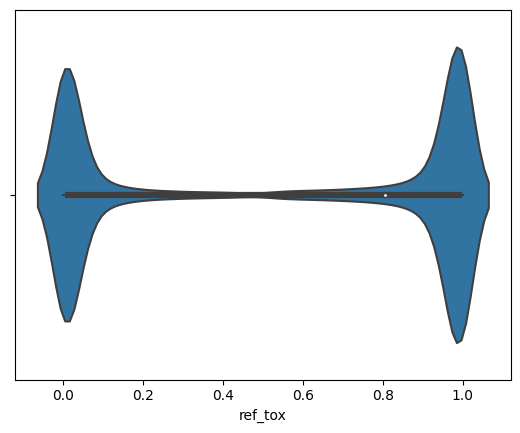

In [ ]:
sns.violinplot(data=df, x='ref_tox')
plt.savefig('violin_plot_ref_unprocessed.png')
plt.show()

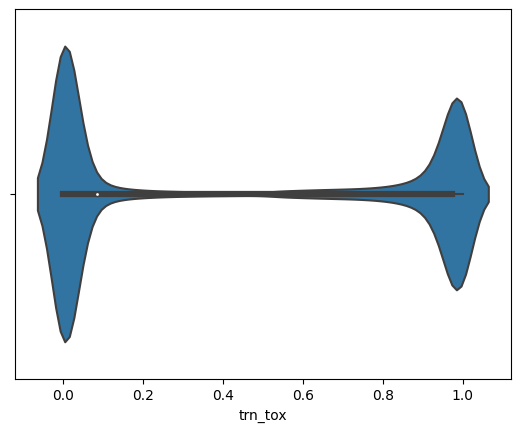

In [ ]:
sns.violinplot(data=df, x='trn_tox', title='')
plt.savefig('violin_plot_trn_unprocessed.png')
plt.show()

#### Dataset needs further preprocessing

Even having the values between 0 and 1 in most of columns and clean word sequences in "reference" and "translation" columns without nans inside, the dataset is unprepared:

   **Violin plot** shows that references have not only toxic sentences, but also detoxified ones (so we need to clearly distinguish which rows have toxic versions in reference column and which have them in translation column). That will be our next task!

In [ ]:
df['toxic'] = df.apply(lambda row: row['reference'] if row['ref_tox'] > row['trn_tox'] else row['translation'], axis=1)
df['toxic_tox'] = df[['ref_tox', 'trn_tox']].max(axis=1)
df['neutral'] = df.apply(lambda row: row['reference'] if row['ref_tox'] <= row['trn_tox'] else row['translation'], axis=1)
df['neutral_tox'] = df[['ref_tox', 'trn_tox']].min(axis=1)

# Drop the old columns
df = df.drop(['reference', 'translation', 'ref_tox', 'trn_tox'], axis=1)

df

,Unnamed: 0,similarity,lenght_diff,toxic,toxic_tox,neutral,neutral_tox
0,0,0.785171,0.010309,"if Alkar floods her with her mental waste, it ...",0.981983,"If Alkar is flooding her with psychic waste, t...",0.014195
1,1,0.749687,0.071429,you're becoming disgusting.,0.999039,Now you're getting nasty.,0.065473
2,2,0.919051,0.268293,"well, we can spare your life.",0.985068,"Well, we could spare your life, for one.",0.213313
3,3,0.664333,0.309524,"monkey, you have to wake up.",0.994215,"Ah! Monkey, you've got to snap out of it.",0.053362
4,4,0.726639,0.181818,I have orders to kill her.,0.999348,I've got orders to put her down.,0.009402
...,...,...,...,...,...,...,...
577772,577772,0.870322,0.030769,you didn't know that Estelle stole your fish f...,0.949143,You didn't know that Estelle had stolen some f...,0.000121
577773,577773,0.722897,0.058824,It'il suck the life out of you!,0.996124,you'd be sucked out of your life!,0.215794
577774,577774,0.617511,0.212121,"I can't fuckin' take that, bruv.",0.984538,I really can't take this.,0.000049
577775,577775,0.679613,0.358209,They called me a fucking hero. The truth is I ...,0.991945,"they said I was a hero, but I didn't care.",0.000124


#### Now we have ready-to-go dataset!

Let us check the toxicity distribution for "toxic" and "neutral" columns, which now correctly distinguish toxic and non-toxic sentences!

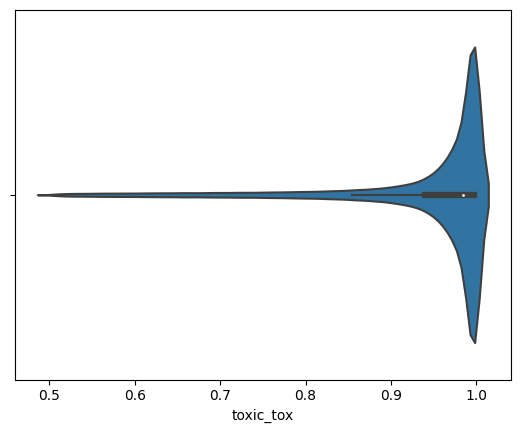

In [ ]:
sns.violinplot(data=df, x='toxic_tox')
plt.savefig('violin_plot_toxic.png')
plt.show()

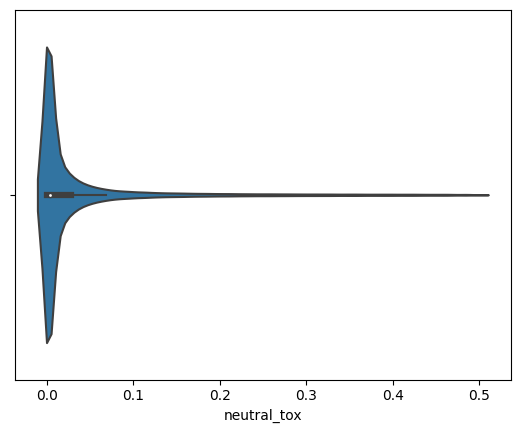

In [ ]:
sns.violinplot(data=df, x='neutral_tox')
plt.savefig('violin_plot_neutral.png')
plt.show()

## One sample
We can see that the toxic language is used in the text placed to "toxic" column (with toxicity rate of 0.985), while neutral paraphrasing is put into "neutral" (it's toxicity value is less than 0.001)

The toxic sentence is really specific, so that is why we have a task to translate it into neutral.


In [ ]:
df.iloc[-3]

Unnamed: 0                               577774
similarity                             0.617511
lenght_diff                            0.212121
toxic          I can't fuckin' take that, bruv.
toxic_tox                              0.984538
neutral               I really can't take this.
neutral_tox                            0.000049
Name: 577774, dtype: object

## Some plots
to examine the data distributions and get useful insights

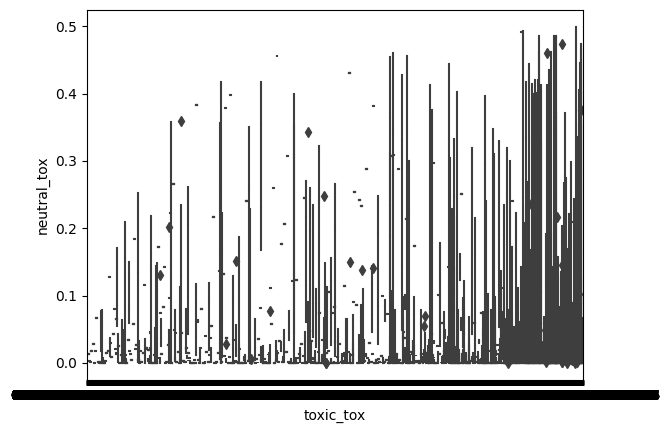

In [ ]:

# Scatter plot
sns.scatterplot(data=df, x='similarity', y='lenght_diff')
plt.savefig('scatter_plot.png')
plt.clf()

sns.boxplot(x="toxic_tox", y="neutral_tox", data=df.iloc[:20000], palette='Set1')
plt.savefig('boxplot_of_toxicity.png')
plt.show()


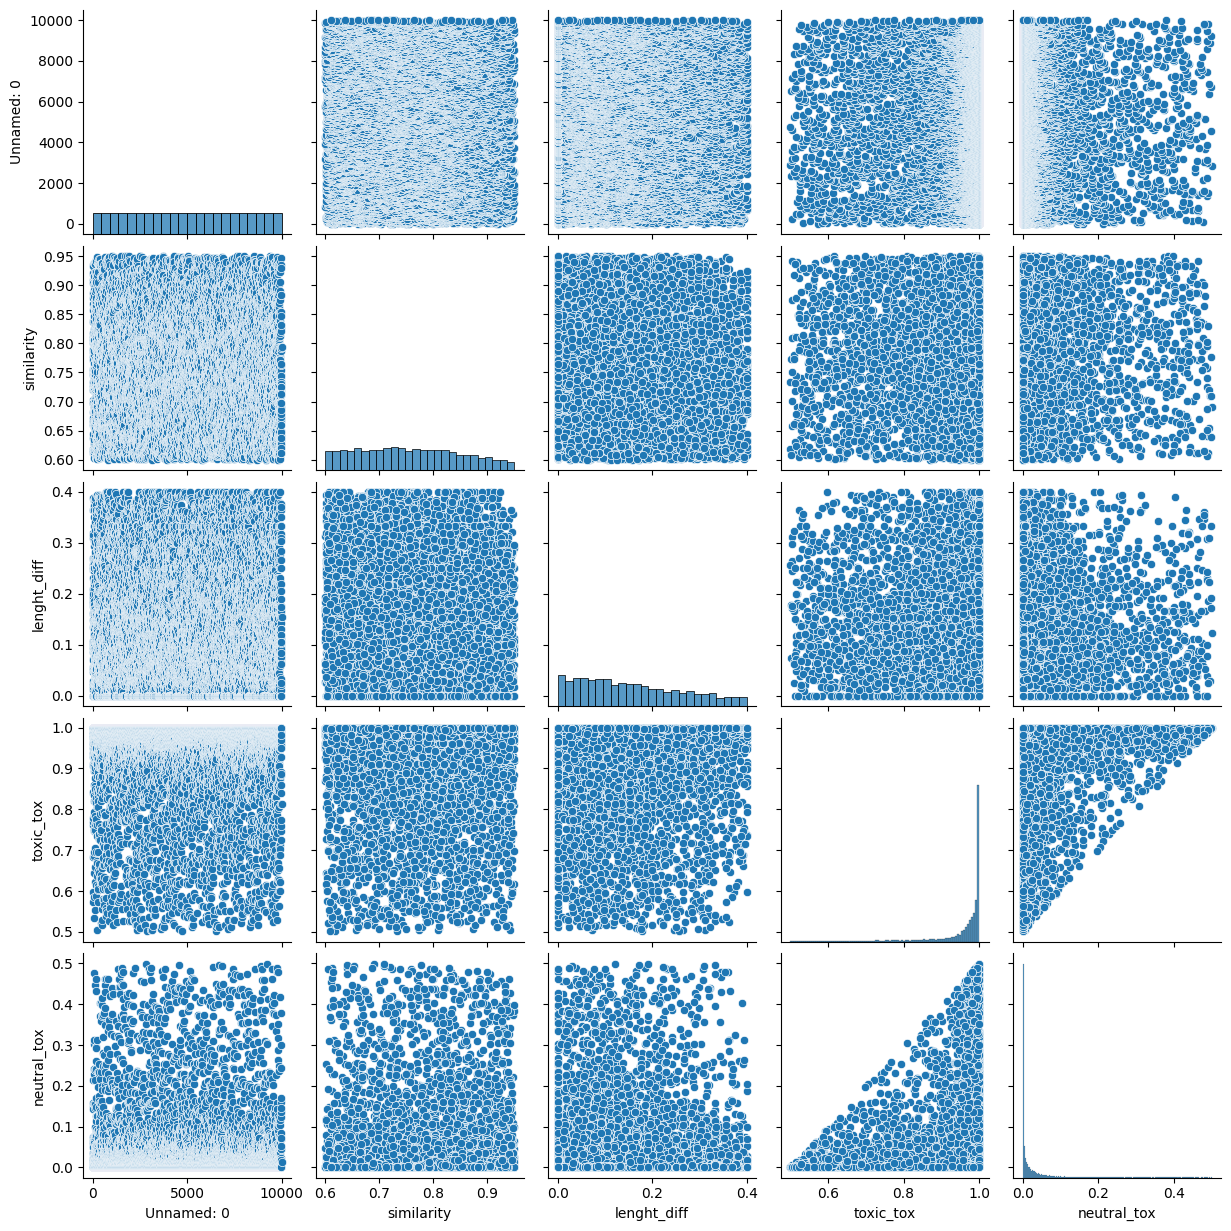

In [ ]:
sns.pairplot(df.iloc[:10000])
plt.savefig('pairplot.png')
plt.show()

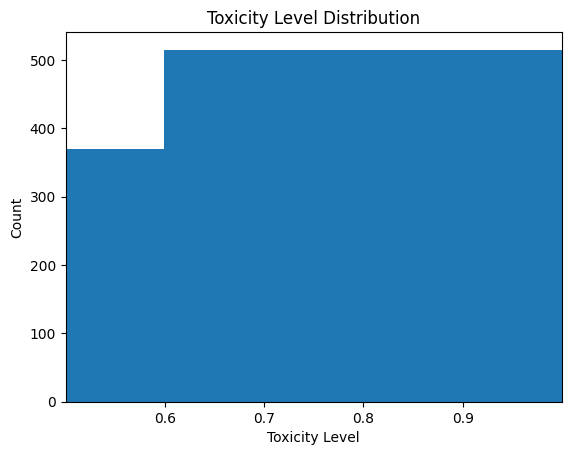

In [ ]:
# Count the number of occurrences for each toxicity level in toxic sentences
toxicity_counts = df['toxic_tox'].value_counts()

# Create a bar plot
plt.bar(toxicity_counts.index, toxicity_counts.values)

# Set plot labels and title
plt.xlabel('Toxicity Level')
plt.ylabel('Count')
plt.title('Toxicity Level Distribution')

# Set x-axis limits
plt.xlim(min(toxicity_counts.index), max(toxicity_counts.index))

# Show the plot
plt.show()

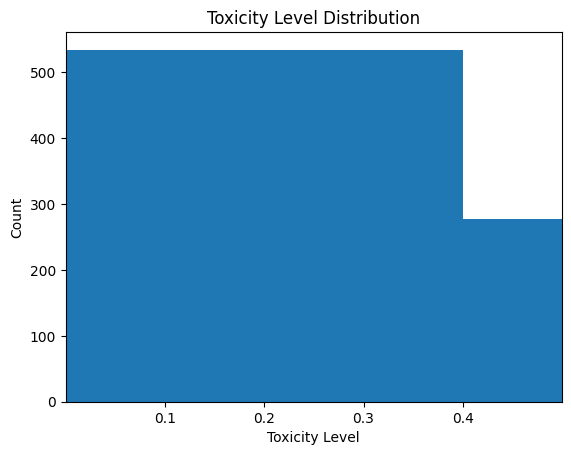

In [ ]:
toxicity_counts = df['neutral_tox'].value_counts()

# Create a bar plot
plt.bar(toxicity_counts.index, toxicity_counts.values)

# Set plot labels and title
plt.xlabel('Toxicity Level')
plt.ylabel('Count')
plt.title('Toxicity Level Distribution')

# Set x-axis limits
plt.xlim(min(toxicity_counts.index), max(toxicity_counts.index))

# Show the plot
plt.show()

In [ ]:
print(f"Range of neutral sentences' toxicity: from {min(toxicity_counts.index)} to {max(toxicity_counts.index)}")

Range of neutral sentences' toxicity: from 3.283871046733111e-05 to 0.4994940161705017


In [ ]:
toxicity_counts = df['toxic_tox'].value_counts()
print(f"Range of toxic sentences' toxicity: from {min(toxicity_counts.index)} to {max(toxicity_counts.index)}")

Range of toxic sentences' toxicity: from 0.5001394152641296 to 0.9997304081916808


### What have we understood?

Data has two columns of sentences: "reference" and "translation". One row of data contains one toxic version of sentence and one neutral. However, they are **shuffled**, meaning that the toxic one can be either in reference column or in translation one. Thus, we have to **determine** which are toxic and which are neutral by "ref_tox" and "trn_tox" columns.

Figures show that toxicity level of neutral sentences is in range (3e-5, 0.5).
Toxicity level of toxic sentences is in range (0.5, 1).

The dataset size is huge, more than 500k samples. We will have to crop it during training for the sake of time efficiency, since we will use already trained models.

Distribution of data seems to be more-or-less even which allows us to crop it quite safely.

All the pairwise dependencies of feature values can be seen on the pairplot above.

#### Now we are ready to proceed to **model** training